# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Есть столбцы в каторых не лишним будет замена типа данных. Например:
* first_day_exposition - хранит дату и время, для него лучше использовать тип данных datetime а не object;
* В следующих столбцах указан тип данных float(число с плавающей точкой): balcony, parks_around3000, ponds_around3000, last_price, days_exposition... их лучше заменить на int, так как он позволяет хранить целочисленные значения.

In [3]:
#Количество явных дубликатов 
data.duplicated().sum()

0

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

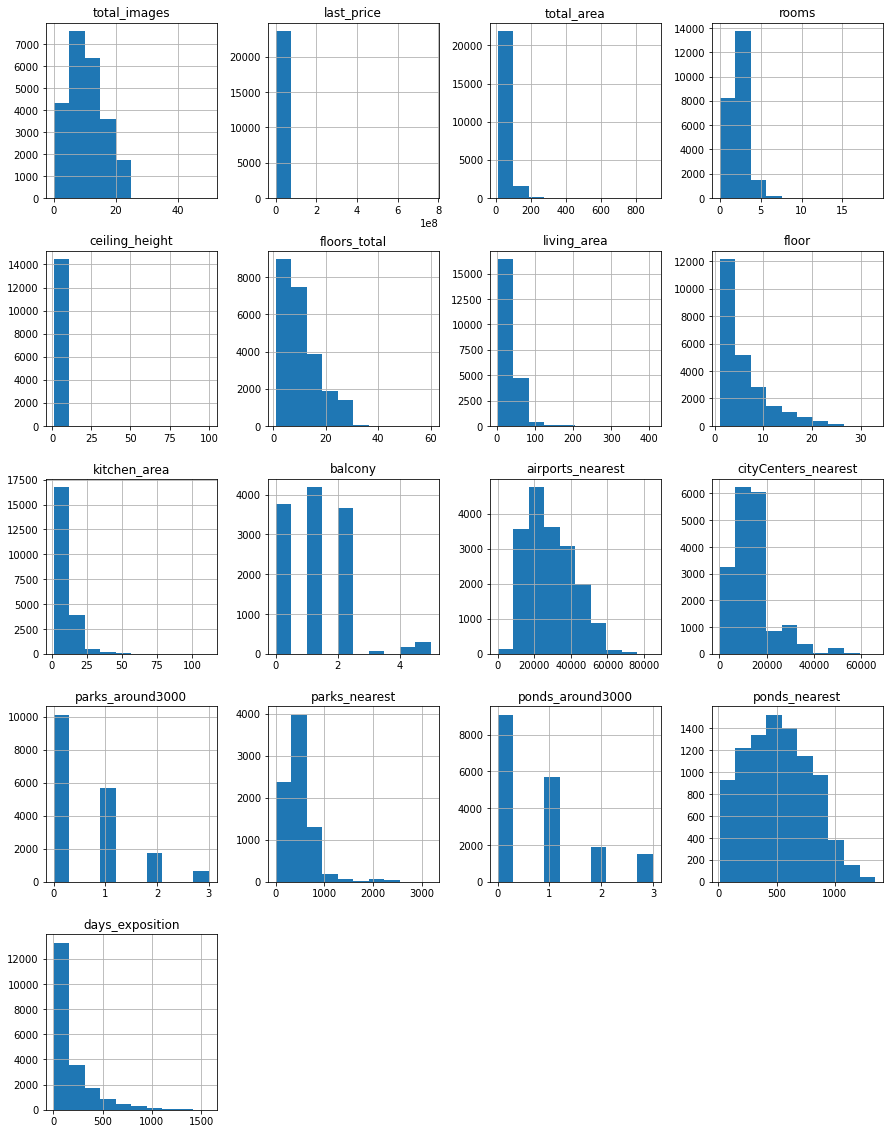

In [4]:
data.hist(figsize=(15, 20))

### Предобработка данных

In [5]:
#количество пропущенных значений в каждом столбце
data.isna().sum() 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


* Столбец 'balcony' хранит данные о числе балконов, возможно это связано с отсутствием балконов, заменим пропущенные значения на 0 и поменяем тип данных на числовой;
* В 'first_day_exposition' изменим способ записи даты, отбросим время так как оно не указано;
* Столбец 'days_exposition' показывает сколько дней было размещено объявление, заменим пропуски на 0 и изменим тип данных на числовой;
* 'last_price' - цена на момент снятия с публикации, изменим тип данных на числовой, для простоты восприятия;
* В 'ponds_around3000' и 'parks_around3000' заполним пропущенные значения на 0 и тип данных поменяем на int. Что интересно в обоих столбцах одинаковое количество пропусков 5518;
* Пропуски в 'ceiling_height' заменили медианным значением

В столбцах где хранится информация о - расстоянии до центра, аэропорта, ближайшего парка и водоёма - получены автоматически, вероятно это повлияло на пропуски в этих данных. Эти данные трогать не будем.

В столбце 'days_exposition' больше всего пропусков за 2019 год. Интересно с чем это может быть связано

In [6]:
#Заполняем пропуски и меняем тип данных
data['balcony'] = data['balcony'].fillna(0).astype('int') 

#Находим median
ch_average = data['ceiling_height'].median() 
#Заполняем пропуски
data['ceiling_height'] = data['ceiling_height'].fillna(value=ch_average)

#Меняем способ записи даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

#Заполняем пропуски и меняем тип данных
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int') 

#Меняем тип данных
data['last_price'] = data['last_price'].astype('int')

#Заполняем пропуски и меняем тип данных
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int') 
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int') 
data['locality_name'] = data['locality_name'].fillna('без имени').astype('str') 

In [7]:
#Количество всех уникальных значенией
data['locality_name'].nunique()

365

In [8]:
data['locality_name'] = data['locality_name'].str.lower()

REPLACE_DICT = {
    'посёлок': 'поселок',
    'село': 'поселок',
    'городской посёлок': 'поселок',
    'посёлок городского типа': 'поселок',
    'коттеджный поселок': 'поселок',
    'поселок станции': 'поселок при железнодорожной станции',
    'садоводческое некоммерческое товарищество': 'садовое товарищество',
    'поселок городского типа': 'поселок'    
}

#Замена значений из словаря
def apply_replace_dict(text):
    
    for key, value in REPLACE_DICT.items():
        text = text.replace(key, value)
        
        return text

In [9]:
data['locality_processing_name'] = data['locality_name'].apply(apply_replace_dict)
data['locality_processing_name'].value_counts()

санкт-петербург                     15721
поселок мурино                        556
поселок шушары                        440
всеволожск                            398
пушкин                                369
                                    ...  
поселок плоское                         1
деревня иссад                           1
деревня старое хинколово                1
деревня каськово                        1
садовое товарищество новая ропша        1
Name: locality_processing_name, Length: 331, dtype: int64

Функция для работы с неявными дубликатами в названиях населённых пунктов

In [10]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [11]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [12]:
# Устраняем редкие и выбивающиеся значения
data = data.loc[(data['total_area'] > 20) & (data['total_area'] < 180)]

In [13]:
# Устраняем редкие и выбивающиеся значения
data.loc[(data['ceiling_height'] >= 22.6) & 
         (data['ceiling_height'] <= 32),'ceiling_height'] = data['ceiling_height'] / 10


data = data.loc[(data['ceiling_height'] > 2) & (data['ceiling_height'] < 5)]

In [14]:
data.sort_values(by='ceiling_height', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_processing_name
2802,7,14950000,50.0,2016-03-06,2,4.80,3.0,30.000000,2,NaN,...,0,санкт-петербург,24433.0,1725.0,1,589.0,3,161.0,160,санкт-петербург
19142,10,8650000,87.7,2017-07-18,2,4.70,26.0,57.400000,26,NaN,...,2,санкт-петербург,40648.0,9888.0,1,1248.0,0,NaN,15,санкт-петербург
3067,13,6600000,95.0,2018-09-08,2,4.50,7.0,45.000000,7,True,...,2,выборг,NaN,NaN,0,NaN,0,NaN,96,выборг
6802,15,7500000,69.0,2017-02-15,2,4.50,3.0,64.000000,3,False,...,0,санкт-петербург,40326.0,15610.0,0,NaN,2,852.0,427,санкт-петербург
10159,14,11500000,85.6,2018-12-18,3,4.50,3.0,63.000000,3,NaN,...,0,санкт-петербург,51944.0,16170.0,0,NaN,2,389.0,34,санкт-петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23498,7,1600000,54.0,2016-12-26,2,2.30,1.0,33.000000,1,False,...,0,высоцк,NaN,NaN,0,NaN,0,NaN,281,высоцк
17762,20,2300000,54.3,2018-06-28,3,2.30,5.0,39.000000,2,NaN,...,1,деревня бегуницы,NaN,NaN,0,NaN,0,NaN,189,деревня бегуницы
20507,12,5950000,60.0,2018-02-19,2,2.26,14.0,35.000000,11,NaN,...,1,санкт-петербург,27028.0,12570.0,0,NaN,0,NaN,40,санкт-петербург
17794,1,2300000,58.6,2016-05-12,3,2.25,5.0,44.100002,3,False,...,1,деревня бегуницы,NaN,NaN,0,NaN,0,NaN,45,деревня бегуницы


В процессе предобработки данных:
- Были найдены и определены пропуски и заполнены там где это возможно. 
- Рассмотрены и изменены типы данных там, где это необходимо.
- Изучены уникальные значения в столбце 'locality_name' с названиями и устранены неявные дубликаты.
- Найдены и устранены редкие и выбивающиеся значения.

### Посчитайте и добавьте в таблицу новые столбцы

- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).


In [15]:
#цена одного квадратного метра;
data['price_square_meter'] = data['last_price'] / data['total_area']
data['price_square_meter'] = data['last_price'].astype('int')

In [16]:
#день недели публикации объявления
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

In [17]:
#месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

In [18]:
#год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

In [19]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
data['floor_type'] = data['floor']

data.loc[~(data['floor_type'] == 1)
                              & ~(data['floor_type'] == data['floors_total']), 'floor_type']='другой'

data.loc[data['floor_type'] == 1, 'floor_type']='первый'

data.loc[data['floor_type'] == data['floors_total'], 'floor_type']='последний'

In [20]:
#расстояние до центра города в километрах 
data['cityCenters_nearest_1'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_1'] = data['cityCenters_nearest_1'].fillna(0).astype('int')
data['cityCenters_nearest_1'] 

0        16
1        18
2        13
3         6
4         8
         ..
23694     4
23695     0
23696     0
23697    10
23698     0
Name: cityCenters_nearest_1, Length: 23322, dtype: int64

### Проведите исследовательский анализ данных

Text(0.5, 1.0, 'График распределения общей площади')

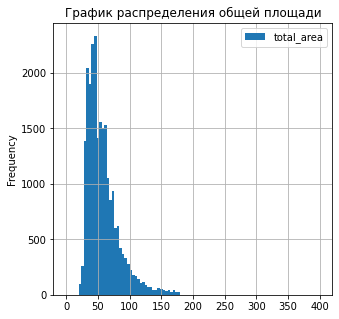

In [21]:
#общая площадь
data.plot(y = 'total_area', kind = 'hist', bins = 100, 
          grid=True, figsize = (5, 5), range = (0, 400))

plt.title('График распределения общей площади')

График 'общая площадь' соответствует нормальному распределению Пуассона. Медианная площад составляет 53м. Max = 179 а Min - 20

Text(0.5, 1.0, 'График распределения жилой площади')

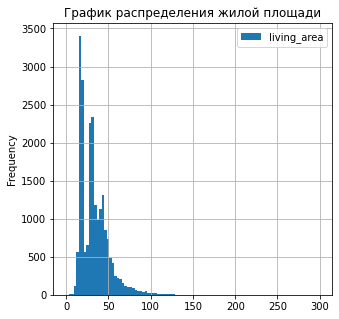

In [22]:
#жилая площадь
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (5, 5), range = (0, 300))
data['living_area'].describe()

plt.title('График распределения жилой площади')

В данных есть выбивающееся значение это min - 2м, Помимо этого, график шероховат. максимальное знакчение 140м. Медиана составляет 30м

Text(0.5, 1.0, 'График распределения площади кухни')

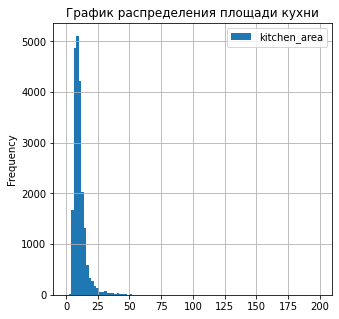

In [23]:
#площадь кухни
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, 
          grid=True, figsize = (5, 5), range = (0, 200))

plt.title('График распределения площади кухни')

График 'площадь кухни' соответствует нормальному распределению Пуассона. Медиана составляет 9м, максимальное значение 77

Text(0.5, 1.0, 'График распределения цены объекта')

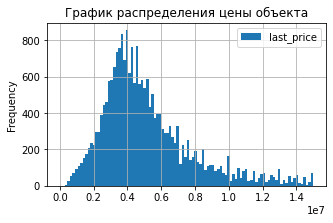

In [24]:
#цена объекта
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0, 15000000), figsize = (5,3))
data['last_price'].describe()

plt.title('График распределения цены объекта')

Медианное значение составляет 4.800000e+06, максимум 1.350000e+08, средняя цена объекта 6.178584e+06

Выбивающееся значение min 1.219000e+04, значение находится за пределами межквартального размаха.

Text(0.5, 1.0, 'График распределения количества комнат')

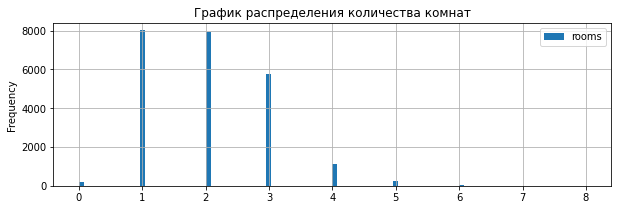

In [25]:
#количество комнат
data.plot(y = 'rooms', kind = 'hist', bins = 100, grid=True, figsize = (10, 3)) 
data['rooms'].describe()

plt.title('График распределения количества комнат')

Среднее количество комнат - 2. Максимум - 8. Межквартальный размах от 1 до 3

Text(0.5, 1.0, 'График распределения высоты потолков')

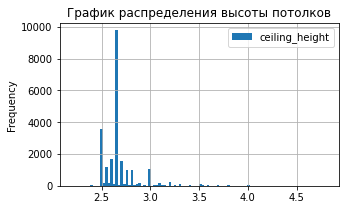

In [26]:
#высота потолков
data.plot(y = 'ceiling_height', kind = 'hist', bins = 100, grid=True, figsize = (5, 3))
data['ceiling_height'].describe()

plt.title('График распределения высоты потолков')

Межквартальный размах от 2.5 до 2.8. Среднее значение 2.7

Text(0.5, 1.0, 'График распределения этажей')

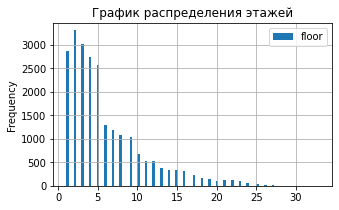

In [27]:
#этаж квартиры
data.plot(y = 'floor', kind = 'hist', bins = 100, grid=True, figsize = (5, 3))
data['floor'].describe()

plt.title('График распределения этажей')

Максимальное число этажей 30, мин 1. Межквартальный размах от 2 до 8 этажей

Text(0, 0.5, 'Количество')

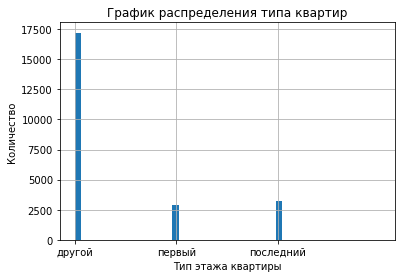

In [28]:
#тип этажа квартиры («первый», «последний», «другой»);
data['floor_type'].hist(bins=50, range=(0, 3))

plt.title('График распределения типа квартир')
plt.xlabel('Тип этажа квартиры')
plt.ylabel('Количество')

На первом этаже 1793 квартир, последнем 2024, на других эатажах в общем 10431 квартир 

Text(0, 0.5, 'Количество')

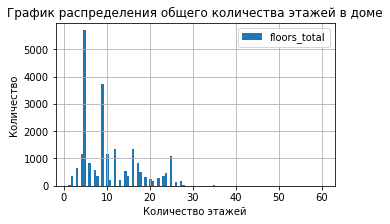

In [29]:
#общее количество этажей в доме
data.plot(y='floors_total', kind = 'hist', 
          bins = 100, grid=True, figsize = (5,3))
data['floors_total'].describe()

plt.title('График распределения общего количества этажей в доме')
plt.xlabel('Количество этажей')
plt.ylabel('Количество')

Межквартильный размах от 5 до 14, в среднем в доме 10 этажей

Text(0, 0.5, 'Количество')

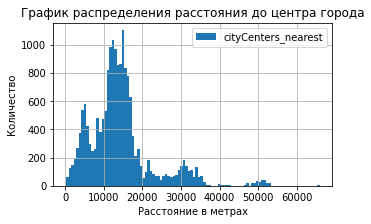

In [30]:
#расстояние до центра города в метрах
data.plot(y = 'cityCenters_nearest', kind = 'hist', 
          bins = 100, grid=True, figsize = (5,3))

data['cityCenters_nearest'].describe()

plt.title('График распределения расстояния до центра города')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество')

В среднем расстояние до центра города в метрах составляет 14204, межквартильный размах от  9364 до 16080

Text(0, 0.5, 'Количество')

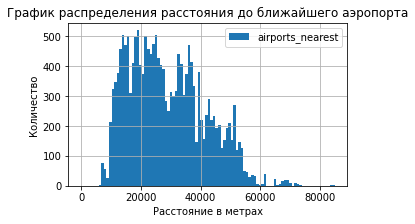

In [31]:
#расстояние до ближайшего аэропорта
data.plot(y = 'airports_nearest', kind = 'hist', 
          bins = 100, grid=True, figsize = (5, 3))

data['cityCenters_nearest'].describe()

plt.title('График распределения расстояния до ближайшего аэропорта')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество')

Межквартильный размах от 9364м до 16080м, в среднем это 14204, минимум 181 метр

Text(0, 0.5, 'Количество')

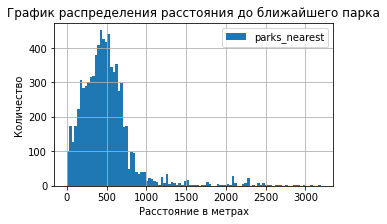

In [32]:
#расстояние до ближайшего парка
data.plot(y = 'parks_nearest', kind = 'hist', 
          bins = 100, grid=True, figsize = (5, 3))

data['parks_nearest'].describe()

plt.title('График распределения расстояния до ближайшего парка')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество')

В среднем до ближайшего парка 478 метров, максимальное значение это 3 километра. Межквартильный размах от 286 до 602 метров. 

Text(0, 0.5, 'Количество')

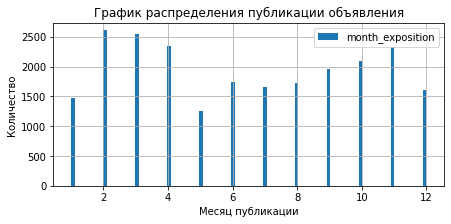

In [33]:
#месяц публикации объявления
data.plot(y = 'month_exposition', kind = 'hist', 
          bins = 100, grid=True, figsize = (7, 3))

plt.title('График распределения публикации объявления')
plt.xlabel('Месяц публикации')
plt.ylabel('Количество')

Больше всего публикаций во 2 и 3 месяце, меньше всего на 5

Text(0, 0.5, 'Количество')

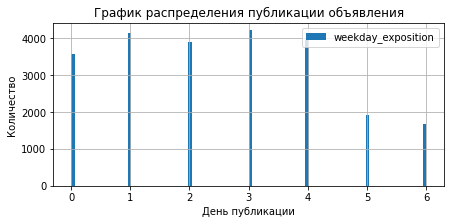

In [34]:
#день публикации объявления
data.plot(y = 'weekday_exposition', kind = 'hist', 
          bins = 100, grid=True, figsize = (7, 3))

plt.title('График распределения публикации объявления')
plt.xlabel('День публикации')
plt.ylabel('Количество')

Больше всего публикаций в будние дни.

2.Как быстро продавались квартиры (столбец days_exposition). 

Text(0.5, 1.0, 'Продажа квартир')

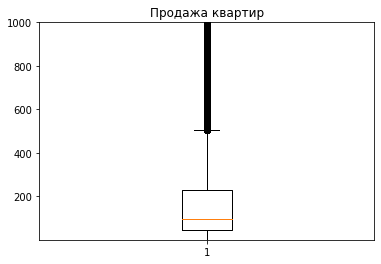

In [35]:
#Диаграмма размаха
plt.boxplot(data[data['days_exposition']!=0]['days_exposition'])
plt.ylim(1, 1000)
plt.title('Продажа квартир')

Text(0, 0.5, 'Количество')

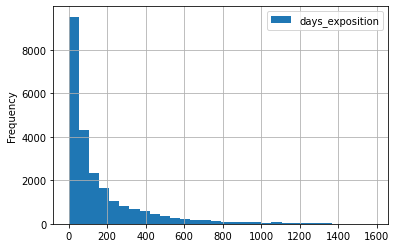

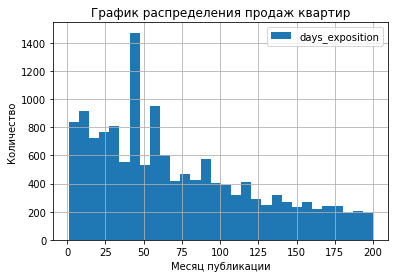

In [36]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True)
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,200))
data[data['days_exposition']!=0]['days_exposition'].describe()

plt.title('График распределения продаж квартир')
plt.xlabel('Месяц публикации')
plt.ylabel('Количество')

На грфике отображено нормальное распределение Пуассона. Среднее значение 190 дней, медиана - 103. Межквартальный размах от 45 до 247 дней. Продажи в пределах 45 дней можно считать быстрыми, длительные от 247. 

0.7127139024030712

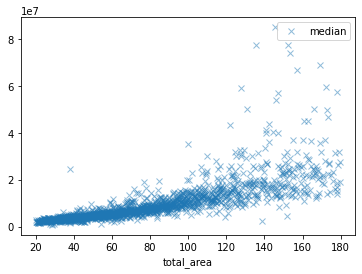

In [37]:
#зависит ли цена от: общей площади; 
total_area_table = data.pivot_table(index='total_area', values='price_square_meter', aggfunc=['mean', 'median', 'count'])

total_area_table.columns = ['mean', 'median', 'count'] #переименуем столбцы

total_area_table.plot(y='median', style = 'x', alpha=0.5)

data['total_area'].corr(data['price_square_meter'])

Чем ближе коэффициент корреляции Пирсона к крайним значениям 1 или -1, тем теснее линейная взаимосвязь. 
В нашем случае корреляция состовляет 0,7 - значит есть зависимость между общей площадью и ценой.

0.5912357678725972

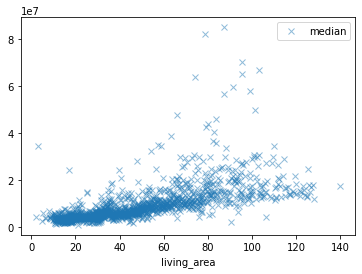

In [38]:
#зависит ли цена от: жилой площади;
living_area_table = data.pivot_table(index='living_area', values='price_square_meter', aggfunc=['mean', 'median', 'count'])

living_area_table.columns = ['mean', 'median', 'count'] #переименуем столбцы

living_area_table.plot(y='median', style = 'x', alpha=0.5)

data['living_area'].corr(data['price_square_meter'])

Коэффициент корреляции состовляет 0.6, зависимость есть, но она не сильно выражена

0.5670751992646138

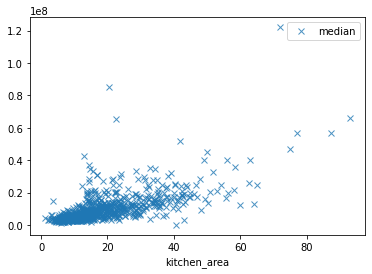

In [39]:
#зависит ли цена от: площади кухни;
kitchen_area_table = data.pivot_table(index='kitchen_area', 
                                      values='price_square_meter', aggfunc=['mean', 'median', 'count'])

#переименуем столбцы
kitchen_area_table.columns = ['mean', 'median', 'count'] 

kitchen_area_table.plot(y='median', style = 'x', alpha=0.8)

data['kitchen_area'].corr(data['price_square_meter'])

Корреляция в 0.5 говорит о наличии связи. Можем предположить что цена зависит от площади кухни, но зависимость не сильная.

0.4157239469169147

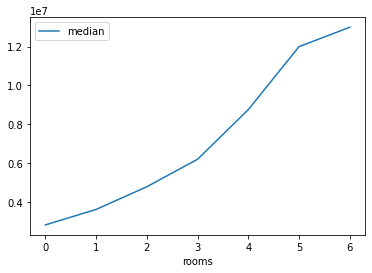

In [40]:
#зависит ли цена от: количества комнат;
rooms_table = data.pivot_table(index='rooms', values='price_square_meter',
                               aggfunc=['mean', 'median', 'count'])

#переименуем столбцы
rooms_table.columns = ['mean', 'median', 'count']
rooms_table.query('count > 40').plot(y = 'median')

data['price_square_meter'].corr(data['rooms'])

Корреляция в 0.4 говорит о наличии связи, чем больше комнат тем выше цена

Text(0, 0.5, 'Количество')

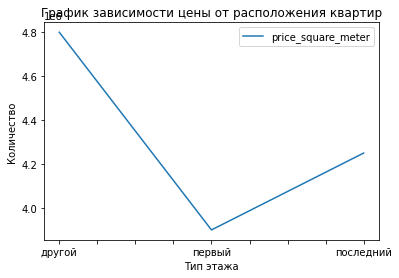

In [41]:
#зависит ли цена от: этажа на котором расположена квартира (первый, последний, другой); 
floor_type_table = (
    data
    .pivot_table(index='floor_type', values='price_square_meter', aggfunc=['mean', 'median', 'count'])
    .plot(y = 'median')
)
floor_type_table

plt.title('График зависимости цены от расположения квартир')
plt.xlabel('Тип этажа')
plt.ylabel('Количество')

Из графика видно, что дешевле квартиры на первом этаже, в отличии от категории 'другой' и 'последний'. Дороже квартиры из категории 'другой'

Text(0, 0.5, 'Количество')

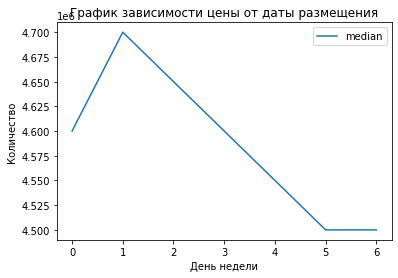

In [42]:
#зависит ли цена от: даты размещения день.
first_day_exposition_table = data.pivot_table(index='weekday_exposition', 
                                              values='price_square_meter', aggfunc=['median', 'count'])

first_day_exposition_table.columns = ['median', 'count'] #переименуем столбцы

first_day_exposition_table.plot(y='median')
first_day_exposition_table.sort_values('median', ascending=False)

plt.title('График зависимости цены от даты размещения')
plt.xlabel('День недели')
plt.ylabel('Количество')

На графике видно, самая высокая отметка приходится на вторник и дальше уже начинает падать вплоть до субботы дальше цена опять начинает рост

Text(0, 0.5, 'Количество')

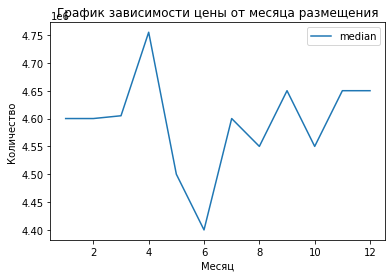

In [43]:
#зависит ли цена от: даты размещения месяц.
first_day_exposition_table = data.pivot_table(index='month_exposition', 
                                              values='price_square_meter', aggfunc=['median', 'count'])

#переименуем столбцы
first_day_exposition_table.columns = ['median', 'count'] 

first_day_exposition_table.plot(y='median')
first_day_exposition_table.sort_values('median', ascending=False)

plt.title('График зависимости цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Количество')

Самая высокая цена в апреле, самая низкая точка цены приходится на июнь

Text(0, 0.5, 'Количество')

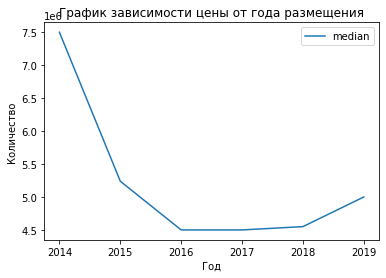

In [44]:
#зависит ли цена от: даты размещения год.
first_day_exposition_table = data.pivot_table(index='year_exposition', 
                                              values='price_square_meter', aggfunc=['median', 'count'])

first_day_exposition_table.columns = ['median', 'count'] #переименуем столбцы

first_day_exposition_table.plot(y='median')
first_day_exposition_table.sort_values('median', ascending=False)

plt.title('График зависимости цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Количество')

Начиная с 2014 и до 2017 года цена начинает падать.  

In [45]:
#средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
ddd = data.pivot_table(index='locality_name', 
                       values='price_square_meter', aggfunc=['mean', 'count'])

ddd.columns = ['mean', 'count']
ddd = ddd.sort_values('count', ascending = False).head(10)
ddd


,mean,count
locality_name,,
санкт-петербург,7.162760e+06,15390
посёлок мурино,3.675738e+06,521
посёлок шушары,4.114023e+06,439
всеволожск,3.799492e+06,396
пушкин,6.112865e+06,362
колпино,3.866289e+06,337
посёлок парголово,4.477609e+06,326
гатчина,3.488337e+06,307
деревня кудрово,4.242326e+06,298


In [46]:
ddd[ddd['mean'] == ddd['mean'].max()]

,mean,count
locality_name,,
санкт-петербург,7.162760e+06,15390


In [47]:
ddd[ddd['mean'] == ddd['mean'].min()]

,mean,count
locality_name,,
выборг,3.183661e+06,233


В 10 населённых пунктах с наибольшим числом объявлений, больше всего число объявлений в городе Санкт-Петербург с количествой 10087 и самой высокой стоимостью за кв метр. Самая низкая цена в городе Гарчина с числом объявлений 149

Text(0.5, 0, 'Расстояние')

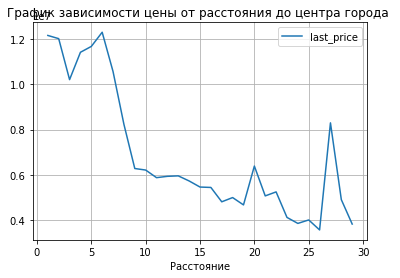

In [48]:
cost_per_kilometer = (
    data
    .query('locality_name == "санкт-петербург" and cityCenters_nearest_1 != 0')
    .pivot_table(index='cityCenters_nearest_1', values='last_price')
    
)

cost_per_kilometer.plot(grid=True)
cost_per_kilometer.head(10)

plt.title('График зависимости цены от расстояния до центра города ')
plt.xlabel('Расстояние')

Можем заметить выбивающиеся значения на 3, 5 и 27км. Изум их подробнее. Растояние ~6км это радиус центра города, сорее всего на 3 и 5км рост обусловлен этим. Цена ближе к центру выше, начиная с 1 и по 7км.

In [49]:
d27 = (data
     .query('locality_name == "санкт-петербург" and cityCenters_nearest_1 == 27')
     .pivot_table(index='floor_type', values='cityCenters_nearest_1', aggfunc='count')
    )
d27.head()

,cityCenters_nearest_1
floor_type,
другой,1
последний,1


На 27км всего одна квартира с типом этажа "другой". Цена достигает 1.435000. Может ли это значение быть аномальным...

In [50]:
d3 = (data
     .query('locality_name == "санкт-петербург" and cityCenters_nearest_1 == 3')
     .pivot_table(index='floor_type', values='cityCenters_nearest_1', aggfunc='count')
    )
d3.head()

,cityCenters_nearest_1
floor_type,
другой,323
первый,72
последний,105


In [51]:
d5 = (data
     .query('locality_name == "санкт-петербург" and cityCenters_nearest_1 == 5')
     .pivot_table(index='floor_type', values='cityCenters_nearest_1', aggfunc='count')
    )
d5.head()

,cityCenters_nearest_1
floor_type,
другой,528
первый,74
последний,102


### Общий вывод

В вашем распоряжении были данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.
В процессе работы были:
- Найдены и изучите пропущенные значения в столбцах;
- Рассмотрены типы данных в каждом столбце;
- Выявлены неявные дубликаты;
- Найдены и устранены редкие и выбивающиеся значения;
- Выявлены факторы больше всего влияют на общую (полную) стоимость объекта: общей площади, жилой площади, площади кухни, количества комнат, этажа, на котором расположена квартира (первый, последний, другой), даты размещения (день недели, месяц, год);
- Узнали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений;
- Узнали как стоимость объектов зависит от расстояния до центра города

Мы изучали средние показатели по рынку в период с 2014 по 2019 гг. 
Среднее время продажи квартиры составляет 190 дней.
В 2015 году цены на квартиры были выше остальных.
Так же мы выявили радиус центра города - 6 км
Узнали что квартиры на первом этаже дешевле